In [1]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, roc_auc_score,
    roc_curve, auc, make_scorer
)
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score
import shap
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import joblib
import numpy as np

c:\Users\nhatk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sentiment_columns = [
        'Reputation', 'Company Communication', 'Appointment', 'Financial', 'Regulatory',
        'Sales', 'M&A', 'Legal', 'Dividend Policy', 'Risks', 'Rumors', 'Strategy',
        'Options', 'IPO', 'Signal', 'Coverage', 'Fundamentals', 'Insider Activity',
        'Price Action', 'Buyside', 'Technical Analysis', 'Trade', 'Central Banks',
        'Currency', 'Conditions', 'Market', 'Volatility', 'Investor Sentiment', 'Retail Investor Behavior',
        'Speculation', 'Domestic Institutional Behavior', 'Foreign Institutional Behavior', 'Black Swan Event',
    ]

sentiment_p1d_columns = [
        'reputation_p1d', 'company_communication_p1d', 'appointment_p1d', 'financial_p1d', 'regulatory_p1d',
        'sales_p1d', 'm&a_p1d', 'legal_p1d', 'dividend_policy_p1d', 'risks_p1d', 'rumors_p1d', 'strategy_p1d',
        'options_p1d', 'ipo_p1d', 'signal_p1d', 'coverage_p1d', 'fundamentals_p1d', 'insider_activity_p1d',
        'price_action_p1d', 'buyside_p1d', 'technical_analysis_p1d', 'trade_p1d', 'central_banks_p1d',
        'currency_p1d', 'conditions_p1d', 'market_p1d', 'volatility_p1d', 'investor_sentiment_p1d', 'retail_investor_behavior_p1d',
        'speculation_p1d', 'domestic_institutional_behavior_p1d', 'foreign_institutional_behavior_p1d', 'black_swan_event_p1d',
    ]
meta_cols = ['num_sa_news', 'mean_sentiment_norm', 'max_sentiment_norm', 'std_sentiment_score', 'sum_positive_sa', 'sum_negative_sa', 'time_distance_from_sa_to_close_minutes']
meta_p1d_cols = ['num_sa_news_p1d', 'mean_sentiment_norm_p1d', 'max_sentiment_norm_p1d', 'std_sentiment_score_p1d', 'sum_positive_sa_p1d', 'sum_negative_sa_p1d', 'time_distance_from_sa_to_close_minutes_p1d']

sentiment_feature_selected =  sentiment_columns + sentiment_p1d_columns + meta_cols + meta_p1d_cols
ta_features = ['volume_ma','volume_to_volume_ma_ratio','ema_12','ema_26','sma_20','sma_50','roc_5','roc_1','roc_9','%K','%R','cci','obv','macd','signal_line','macd_histogram','rsi','rsi_base_ma','rsi_rsi_base_ma_ratio','bb_bbm','bb_bbh','bb_bbl','bb_bbp','bb_bbh_bb_bbl_ratio','hl_ratio', 'co_ratio', 'price_range', 'sma_ratio_20_50', 'ema_ratio_12_26', 'bb_width', 'bb_position', 'rsi_overbought', 'rsi_oversold', 'rsi_neutral', 'macd_bullish', 'momentum_5', 'momentum_10','log_return','volatility_5d','volatility_10d','volatility_20d','volatility_30d','mean_log_return_5d','mean_log_return_10d','mean_log_return_20d','mean_log_return_30d','sharpe_like_5d','sharpe_like_10d','sharpe_like_20d','sharpe_like_30d','up_streak','pos_log_return_ratio_20d','z_score_5d','z_score_10d','z_score_20d','z_score_30d','annual_return','daily_return','sharpe_ratio',
               'rsi_vn30','rsi_base_ma_vn30','rsi_rsi_base_ma_ratio_vn30','volume_ma_vn30','volume_to_volume_ma_ratio_vn30','bb_bbm_vn30','bb_bbh_vn30','bb_bbl_vn30','bb_bbp_vn30','bb_bbh_bb_bbl_ratio_vn30','roc_1_vn30', 'roc_5_vn30', 'roc_9_vn30','%K_vn30','%R_vn30','cci_vn30','obv_vn30','ema_12_vn30','ema_26_vn30','sma_20_vn30','sma_50_vn30', 'hl_ratio_vn30', 'co_ratio_vn30', 'price_range_vn30', 'sma_ratio_20_50_vn30', 'ema_ratio_12_26_vn30', 'bb_width_vn30', 'bb_position_vn30', 'rsi_overbought_vn30', 'rsi_oversold_vn30', 'rsi_neutral_vn30', 'momentum_5_vn30', 'momentum_10_vn30', 'log_return_vn30','volatility_5d_vn30','volatility_10d_vn30','volatility_20d_vn30','volatility_30d_vn30','mean_log_return_5d_vn30','mean_log_return_10d_vn30','mean_log_return_20d_vn30','mean_log_return_30d_vn30','sharpe_like_5d_vn30','sharpe_like_10d_vn30','sharpe_like_20d_vn30','sharpe_like_30d_vn30','up_streak_vn30','pos_log_return_ratio_20d_vn30','z_score_5d_vn30','z_score_10d_vn30','z_score_20d_vn30','z_score_30d_vn30','annual_return_vn30','daily_return_vn30','sharpe_ratio_vn30',
               'rsi_vni','rsi_base_ma_vni','rsi_rsi_base_ma_ratio_vni','volume_ma_vni','volume_to_volume_ma_ratio_vni','bb_bbm_vni','bb_bbh_vni','bb_bbl_vni','bb_bbp_vni','bb_bbh_bb_bbl_ratio_vni','roc_1_vni', 'roc_5_vni', 'roc_9_vni','%K_vni','%R_vni','cci_vni','obv_vni','ema_12_vni','ema_26_vni','sma_20_vni','sma_50_vni', 'hl_ratio_vni', 'co_ratio_vni', 'price_range_vni', 'sma_ratio_20_50_vni', 'ema_ratio_12_26_vni', 'bb_width_vni', 'bb_position_vni', 'rsi_overbought_vni', 'rsi_oversold_vni', 'rsi_neutral_vni', 'momentum_5_vni', 'momentum_10_vni','log_return_vni','volatility_5d_vni','volatility_10d_vni','volatility_20d_vni','volatility_30d_vni','mean_log_return_5d_vni','mean_log_return_10d_vni','mean_log_return_20d_vni','mean_log_return_30d_vni','sharpe_like_5d_vni','sharpe_like_10d_vni','sharpe_like_20d_vni','sharpe_like_30d_vni','up_streak_vni','pos_log_return_ratio_20d_vni','z_score_5d_vni','z_score_10d_vni','z_score_20d_vni','z_score_30d_vni','annual_return_vni','daily_return_vni','sharpe_ratio_vni']
fa_features = ['p/b_previous_quarter', 'p/b_change_rate','p/b_change_rate_flag','p/e_previous_quarter','p/e_change_rate','p/e_change_rate_flag','p/s_previous_quarter','p/s_change_rate','p/s_change_rate_flag','p/cash_flow_previous_quarter','p/cash_flow_change_rate','p/cash_flow_change_rate_flag','eps_previous_quarter','eps_change_rate', 'eps_change_rate_flag','bvps_previous_quarter','bvps_change_rate', 'bvps_change_rate_flag','roe_previous_quarter','roe_change_rate','roe_change_rate_flag','roa_previous_quarter','roa_change_rate','roa_change_rate_flag','coefficient_p/b','coefficient_p/e','coefficient_p/s','coefficient_p/cash_flow','coefficient_eps','coefficient_bvps','coefficient_roe','coefficient_roa','distance_to_nearest_quarter']
ta_fa_feature_selected = ta_features + fa_features
features = ta_fa_feature_selected + sentiment_feature_selected

In [9]:
# Load scaler và model cho TA+FA
ft_scaler = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\ft_scaler.pkl')
ft_xgb_model = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\ft_xgb_model.pkl')

In [10]:
# Load scaler và model cho TA+FA+SA
fts_scaler = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\fts_scaler.pkl')
fts_xgb_model = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\fts_xgb_model.pkl')

In [7]:
# load test_data
def dataframe_to_x_y(df, feature, target):
  X_train, y_train = [], []
  X_val, y_val = [], []
  n = len(df)
  split_index = int(n * 0.8)
  X_train = df[feature][:split_index]
  y_train = df[target][:split_index]
  X_val = df[feature][split_index:]
  y_val = df[target][split_index:]
  return X_train, y_train, X_val, y_val


def load_data_for_analysis(tickers, folder_path):

    df_all = []

    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.xlsx")
        if os.path.exists(file_path):
            df = pd.read_excel(file_path)
            df["ticker"] = ticker  # thêm cột ticker
            df_all.append(df)
        else:
            print(f"⚠️ Không tìm thấy: {file_path}")

    # Gộp lại thành 1 DataFrame
    df_global = pd.concat(df_all, ignore_index=True)
    print(f"✅ Đã load xong {len(df_global)} dòng dữ liệu từ {len(df_all)} cổ phiếu.")
    return df_global

tickers = ['ACB', 'BCM', 'BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG',
                    'LPB','MBB','MSN','MWG','PLX','SAB','SHB','SSB','SSI','STB',
                    'TCB','TPB','VCB','VHM','VIB','VIC','VJC','VNM','VPB','VRE']
# folder_path_train = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\data\v6\stock_trend\train_data" 
folder_path_test = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\data\v6\stock_trend\test_data" 
# df_global_train = load_data_for_analysis(tickers, folder_path_train)
df_global_test = load_data_for_analysis(tickers, folder_path_test)

✅ Đã load xong 7380 dòng dữ liệu từ 30 cổ phiếu.


In [8]:
# Copy dataframe kết quả
df_result = df_global_test.copy()

In [9]:
# Dự đoán với mô hình TA+FA
X_ft = df_global_test[ta_fa_feature_selected]
X_ft_scaled = ft_scaler.transform(X_ft)
df_result['ft_xgb_model_predict'] = ft_xgb_model.predict(X_ft_scaled)

In [10]:
# Dự đoán với mô hình TA+FA+SA
X_fts = df_global_test[features]
X_fts_scaled = fts_scaler.transform(X_fts)
df_result['fts_xgb_model_predict'] = fts_xgb_model.predict(X_fts_scaled)

In [11]:
df_result.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\df_result_predict.xlsx", index=False)

In [12]:
# Tạo mask cho ngày không có tin tức (tất cả sentiment_feature_selected == 0)
no_news_mask = (df_result[sentiment_feature_selected].abs().sum(axis=1) == 0)
# Tạo mask cho ngày có tin tức (ít nhất 1 sentiment_feature_selected khác 0)
has_news_mask = (df_result[sentiment_feature_selected].abs().sum(axis=1) > 0)

In [13]:
# Đảm bảo dữ liệu đã được sort theo ticker và ngày (giả sử có cột 'date')
df_result_sorted = df_result.sort_values(['ticker', 'time']).reset_index(drop=True)

In [14]:
# Tạo các mảng để dễ truy cập
tickers = df_result_sorted['ticker'].values
targets = df_result_sorted['target'].values
fts_preds = df_result_sorted['fts_xgb_model_predict'].values
ft_preds = df_result_sorted['ft_xgb_model_predict'].values
no_news = no_news_mask.values
has_news = has_news_mask.values

In [15]:
# Trường hợp 1: Tin tức tiêu cực đảo chiều từ Buy -> Sell
case1_rows = []
for i in range(1, len(df_result_sorted)):
    # Cùng ticker, ngày hôm trước không có tin tức, hôm sau có tin tức
    if (tickers[i] == tickers[i-1]) and no_news[i-1] and has_news[i]:
        # Hôm trước: fts dự báo Buy và đúng ground truth
        if fts_preds[i-1] == 2 and targets[i-1] == 2:
            # Hôm sau: fts dự báo Sell và đúng ground truth
            if fts_preds[i] == 0 and targets[i] == 0:
                # ft_xgb_model dự đoán sai (Buy hoặc Hold)
                if ft_preds[i] in [1, 2]:
                    case1_rows.append(i)

df_case1 = df_result_sorted.iloc[case1_rows].copy()

In [16]:
# Trường hợp 2: Tin tức tích cực đảo chiều từ Sell -> Buy
case2_rows = []
for i in range(1, len(df_result_sorted)):
    if (tickers[i] == tickers[i-1]) and no_news[i-1] and has_news[i]:
        # Hôm trước: fts dự báo Sell và đúng ground truth
        if fts_preds[i-1] == 0 and targets[i-1] == 0:
            # Hôm sau: fts dự báo Buy và đúng ground truth
            if fts_preds[i] == 2 and targets[i] == 2:
                # ft_xgb_model dự đoán sai (Sell hoặc Hold)
                if ft_preds[i] in [0, 1]:
                    case2_rows.append(i)

df_case2 = df_result_sorted.iloc[case2_rows].copy()

In [17]:
# Lưu ra file Excel nếu muốn
df_case1.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\case1_negative_news_effect.xlsx", index=False)
df_case2.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\case2_positive_news_effect.xlsx", index=False)

In [18]:
# Minh chứng 1: Có tin tức, fts đúng Buy, ft sai
mask_case1 = (
    (has_news_mask) &
    (df_result['fts_xgb_model_predict'] == 2) &
    (df_result['target'] == 2) &
    (df_result['ft_xgb_model_predict'] != 2)
)
df_evidence1 = df_result[mask_case1].copy()

# Minh chứng 2: Có tin tức, fts đúng Sell, ft sai
mask_case2 = (
    (has_news_mask) &
    (df_result['fts_xgb_model_predict'] == 0) &
    (df_result['target'] == 0) &
    (df_result['ft_xgb_model_predict'] != 0)
)
df_evidence2 = df_result[mask_case2].copy()

In [ ]:
df_evidence1.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_buy_news.xlsx", index=False)
df_evidence2.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_sell_news.xlsx", index=False)

In [3]:
df_evidence1 = pd.read_excel(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_buy_news.xlsx')
df_evidence2 = pd.read_excel(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_sell_news.xlsx')

In [4]:
import shap
import matplotlib.pyplot as plt

In [7]:
# Lấy dữ liệu đầu vào cho mô hình fts (TA+FA+SA) tương ứng với các dòng minh chứng
X_evidence1 = df_evidence1[features]
X_evidence2 = df_evidence2[features]

In [11]:
# Giả sử bạn đã load fts_scaler từ trước
X_evidence1_scaled = fts_scaler.transform(X_evidence1)
X_evidence2_scaled = fts_scaler.transform(X_evidence2)

In [12]:
# Tạo explainer cho mô hình fts_xgb_model
explainer = shap.TreeExplainer(fts_xgb_model)

In [13]:
# Tính giá trị shap cho từng minh chứng
shap_values1 = explainer.shap_values(X_evidence1_scaled)

In [14]:
print(type(shap_values1))
print(np.shape(shap_values1))

<class 'numpy.ndarray'>
(108, 282, 3)


In [15]:
shap_values2 = explainer.shap_values(X_evidence2_scaled)

In [16]:
print(type(shap_values2))
print(np.shape(shap_values2))

<class 'numpy.ndarray'>
(97, 282, 3)


In [32]:
# Kiểm tra số feature đầu vào
print("Shape X_evidence1:", X_evidence1.shape)
print("Shape X_evidence2:", X_evidence2.shape)
print("Số lượng features:", len(features))
print("Số lượng feature cảm xúc:", len(sentiment_feature_selected))

Shape X_evidence1: (108, 282)
Shape X_evidence2: (97, 282)
Số lượng features: 282
Số lượng feature cảm xúc: 80


In [17]:
# Lấy SHAP values cho class 2 (Buy) và class 0 (Sell)
# Nếu shap_values1 là list, mỗi phần tử là (n_samples, n_features)
shap_values1_class2 = shap_values1[:, :, 2]  # (108, 282)
shap_values2_class0 = shap_values2[:, :, 0]  # (97, 282)

In [40]:
print("Shape shap_values1_class2:", shap_values1_class2.shape)
print("Shape shap_values2_class0:", shap_values2_class0.shape)

Shape shap_values1_class2: (108, 282)
Shape shap_values2_class0: (97, 282)


In [18]:
# Lấy index các feature cảm xúc
sentiment_idx = [features.index(col) for col in sentiment_feature_selected]

# Lấy SHAP values của các feature cảm xúc
shap_values1_sentiment = shap_values1_class2[:, sentiment_idx]  # (108, 80)
shap_values2_sentiment = shap_values2_class0[:, sentiment_idx]  # (97, 80)

print("Shape shap_values1_sentiment:", shap_values1_sentiment.shape)
print("Shape shap_values2_sentiment:", shap_values2_sentiment.shape)

Shape shap_values1_sentiment: (108, 80)
Shape shap_values2_sentiment: (97, 80)


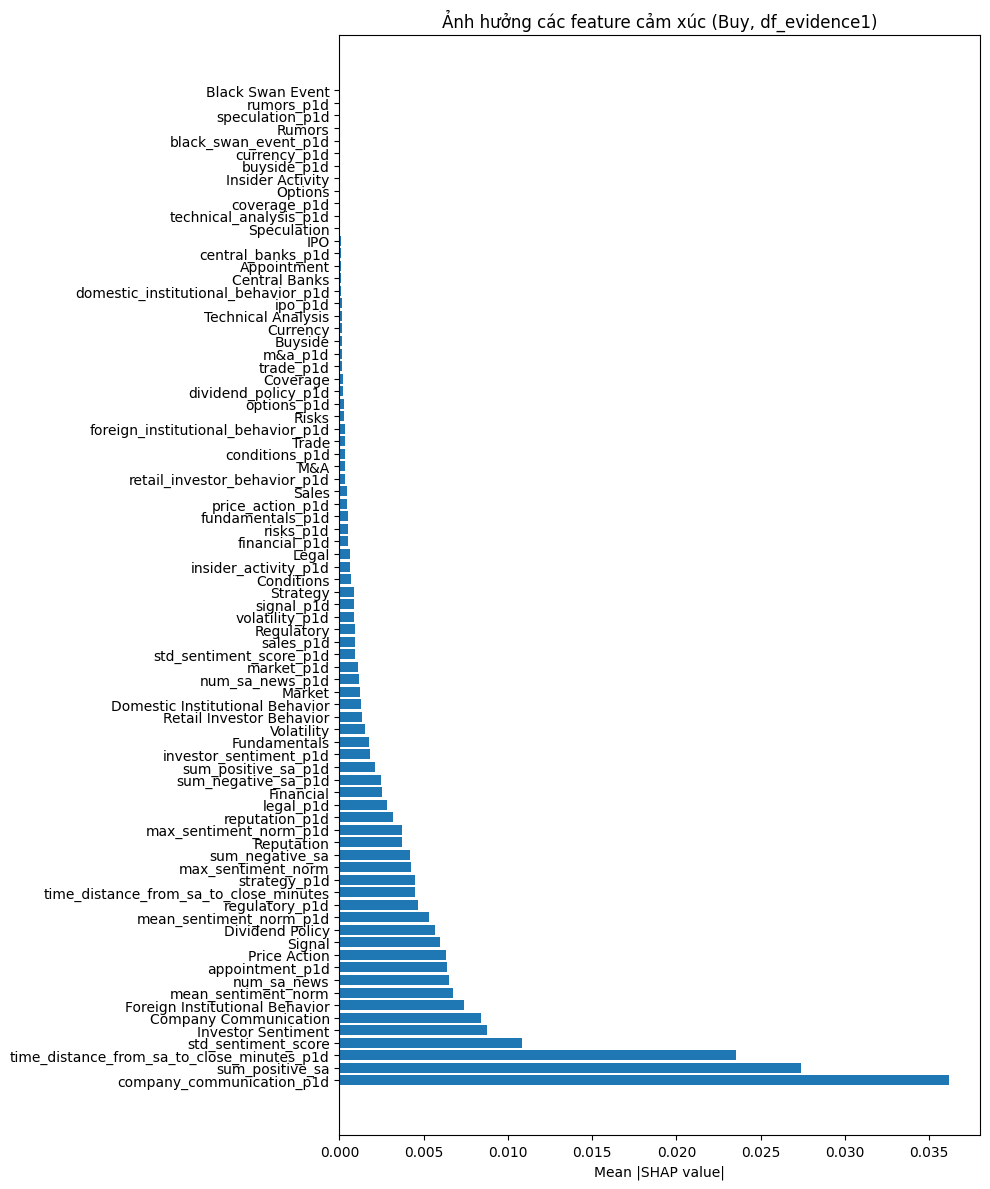

In [43]:
mean_abs_shap1 = np.abs(shap_values1_sentiment).mean(axis=0)
sorted_idx1 = mean_abs_shap1.argsort()[::-1]

plt.figure(figsize=(10, 12))
plt.barh(np.array(sentiment_feature_selected)[sorted_idx1], mean_abs_shap1[sorted_idx1])
plt.xlabel("Mean |SHAP value|")
plt.title("Ảnh hưởng các feature cảm xúc (Buy, df_evidence1)")
plt.tight_layout()
plt.show()

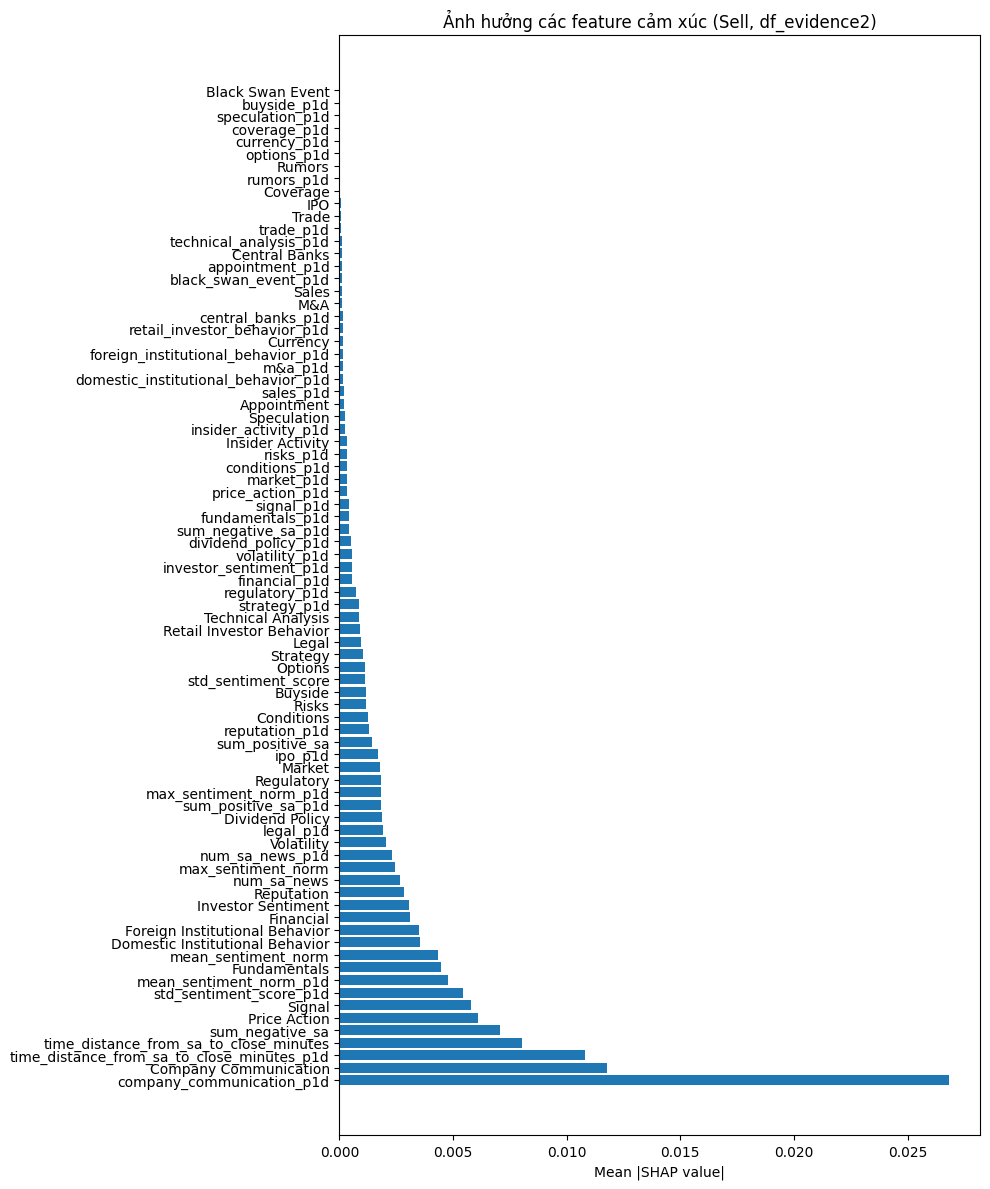

In [44]:
mean_abs_shap2 = np.abs(shap_values2_sentiment).mean(axis=0)
sorted_idx2 = mean_abs_shap2.argsort()[::-1]

plt.figure(figsize=(10, 12))
plt.barh(np.array(sentiment_feature_selected)[sorted_idx2], mean_abs_shap2[sorted_idx2])
plt.xlabel("Mean |SHAP value|")
plt.title("Ảnh hưởng các feature cảm xúc (Sell, df_evidence2)")
plt.tight_layout()
plt.show()

In [61]:
# Plot function
def safe_shap_plot(shap_vals, X, feature_names, class_idx, class_name):
    try:
        if shap_vals.ndim == 3:
            shap_for_class = shap_vals[:, :, class_idx]
        else:
            shap_for_class = shap_vals
        
        if shap_for_class.shape[1] == len(feature_names) + 1:
            shap_for_class = shap_for_class[:, :-1]
        
        n_features = min(shap_for_class.shape[1], X.shape[1], len(feature_names))
        X_df = pd.DataFrame(X[:, :n_features], columns=feature_names[:n_features])
        shap_plot_data = shap_for_class[:, :n_features]

        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=True  # Hiển thị màu
        )

        plt.title(f'Top 5 most influential sentiment features on {class_name} decision', fontsize=16, fontweight='bold')
        plt.xlabel('SHAP', fontsize=14)
        plt.ylabel('Feature', fontsize=14)

        # Chú thích màu sắc
        # plt.figtext(0.5, -0.05,
        #             '🔵 Màu biểu diễn giá trị feature: xanh = thấp, hồng = cao',
        #             ha='center', fontsize=13, color='black')

        plt.tight_layout()
        plt.show()
        return True

    except Exception as e:
        print(f"❌ Error for {class_name}: {e}")
        return False

In [ ]:
import matplotlib as mpl
# Set global font
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['font.size'] = 14

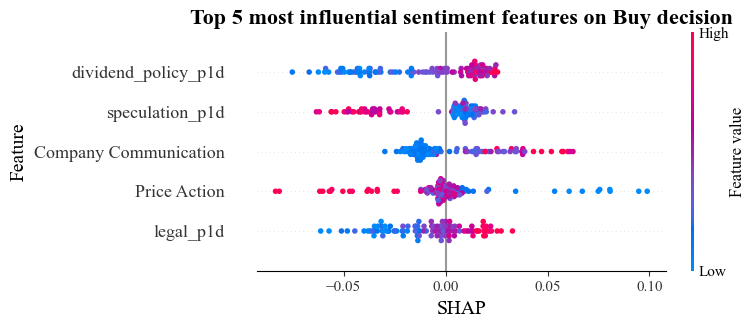

In [62]:
 success = safe_shap_plot(shap_values1, X_evidence1_scaled, sentiment_feature_selected, 2, 'Buy')

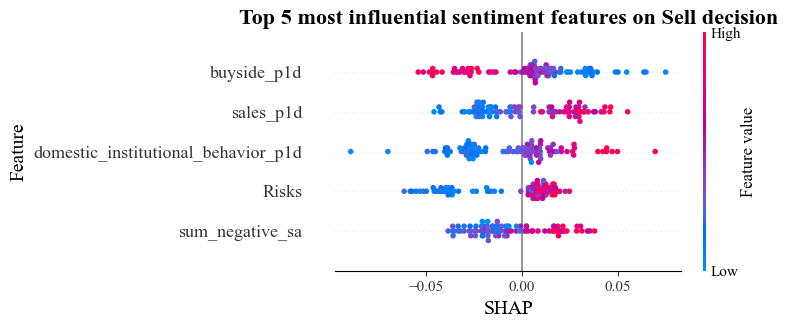

In [63]:
success = safe_shap_plot(shap_values2, X_evidence2_scaled, sentiment_feature_selected, 0, 'Sell')

In [68]:
# Plot function
def safe_shap_plot_custom_name(shap_vals, X, feature_names, class_idx, class_name, custom_names):
    try:
        if shap_vals.ndim == 3:
            shap_for_class = shap_vals[:, :, class_idx]
        else:
            shap_for_class = shap_vals
        
        if shap_for_class.shape[1] == len(feature_names) + 1:
            shap_for_class = shap_for_class[:, :-1]
        
        n_features = min(shap_for_class.shape[1], X.shape[1], len(feature_names))
        X_df = pd.DataFrame(X[:, :n_features], columns=feature_names[:n_features])
        shap_plot_data = shap_for_class[:, :n_features]

# Tạo figure để lấy thông tin feature quan trọng nhất
        plt.figure()
        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=True
        )
        ax = plt.gca()
        # Lấy tên feature gốc trên trục y (top 5 feature)
        yticklabels = [tick.get_text() for tick in ax.get_yticklabels()]
        plt.close()  # Đóng figure tạm

        # Tạo mapping custom_names <-> feature gốc
        if custom_names is None:
            custom_names = [str(i+1) for i in range(len(yticklabels))]
        mapping = {custom_names[i]: yticklabels[i] for i in range(len(yticklabels))}

        # Đổi tên trục y bằng custom_names
        plt.figure()
        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=False
        )
        ax = plt.gca()
        ax.set_yticklabels(custom_names)
        # Làm đậm từng label trục y
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        # plt.title(f'Top 5 most influential sentiment features on {class_name} decision', fontsize=16, fontweight='bold')
        plt.xlabel('SHAP', fontsize=14)
        # plt.ylabel('Feature', fontsize=14)
        # plt.tight_layout()
        ax.xaxis.label.set_visible(False)
        ax.tick_params(axis='x', labelsize=24)  # chỉnh kích thước số/tên trục hoành
        ax.tick_params(axis='y', labelsize=24)  # chỉnh kích thước số/tên trục tung
        plt.show()

        print("Feature index mapping:")
        for k, v in mapping.items():
            print(f"{k}: {v}")

        return True


    except Exception as e:
        print(f"❌ Error for {class_name}: {e}")
        return False

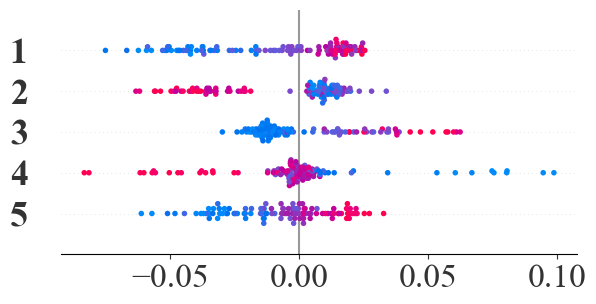

Feature index mapping:
5: legal_p1d
4: Price Action
3: Company Communication
2: speculation_p1d
1: dividend_policy_p1d


In [64]:
success = safe_shap_plot_custom_name(shap_values1, X_evidence1_scaled, sentiment_feature_selected, 2, 'Buy', custom_names=["5", "4", "3", "2", "1"])

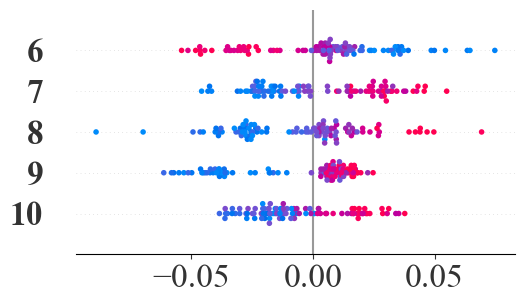

Feature index mapping:
10: sum_negative_sa
9: Risks
8: domestic_institutional_behavior_p1d
7: sales_p1d
6: buyside_p1d


In [69]:
success = safe_shap_plot_custom_name(shap_values2, X_evidence2_scaled, sentiment_feature_selected, 0, 'Sell', custom_names=["10", "9", "8", "7", "6"])